In [1]:
import os
import shutil

from functools import partial
from time import time

import dask.dataframe as dd
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sid import get_colors
from src.config import SRC, BLD

from sid import get_simulate_func

from src.create_initial_states.create_initial_conditions import (  # noqa
    create_initial_conditions,
)
 
from src.policies.combine_policies_over_periods import get_october_to_christmas_policies
from src.policies.combine_policies_over_periods import get_enacted_policies_of_2021

from src.simulation.main_specification import load_simulation_inputs
from src.simulation.main_specification import SIMULATION_DEPENDENCIES
from src.simulation.main_specification import SCENARIO_START

from sid import get_msm_func
from src.manfred.shared import hash_array
from estimagic.batch_evaluators import joblib_batch_evaluator
from sid.msm import get_diag_weighting_matrix

from src.calculate_moments import smoothed_outcome_per_hundred_thousand_rki
from src.calculate_moments import smoothed_outcome_per_hundred_thousand_sim

from src.policies.policy_tools import combine_dictionaries

SAVED_COLUMNS = {
    "initial_states": ["age_group_rki"],
    "disease_states": ["newly_infected", "infectious", "ever_infected"],
    "time": ["date"],
    "other": [
        "new_known_case",
        "virus_strain",
        "n_has_infected",
        "pending_test",
    ],
}


plt.rcParams.update(
    {
        "axes.spines.right": False,
        "axes.spines.top": False,
        "legend.frameon": False,
    }
)

print(SCENARIO_START.date())

2021-04-06


# Load the fall and spring simulation inputs

In [2]:
# spring

spring_start_date = pd.Timestamp("2021-02-05")
spring_end_date = spring_start_date + pd.Timedelta(weeks=1) ### 4
spring_init_start = spring_start_date - pd.Timedelta(31, unit="D")
print(spring_init_start.date(), spring_end_date.date())
spring_init_end = spring_start_date - pd.Timedelta(1, unit="D")

virus_shares, spring_kwargs = load_simulation_inputs(
    SIMULATION_DEPENDENCIES, spring_init_start, spring_end_date, extend_ars_dfs=False
)
# we don't want to parse the "old" params
spring_kwargs.pop("params")

full_spring_simulate_inputs = {
    "duration": {"start": spring_start_date, "end": spring_end_date},
    "initial_conditions": create_initial_conditions(
        start=spring_init_start,
        end=spring_init_end,
        seed=3930,
        reporting_delay=5,
        virus_shares=virus_shares,
    ),
    "contact_policies": get_enacted_policies_of_2021(
        contact_models=spring_kwargs["contact_models"],
        scenario_start=SCENARIO_START,
    ),
    "saved_columns": SAVED_COLUMNS,
    **spring_kwargs
}

2021-01-05 2021-02-12


In [3]:
# fall 

fall_start_date = pd.Timestamp("2020-12-13") ### pd.Timestamp("2020-10-15")
fall_init_start = fall_start_date - pd.Timedelta(31, unit="D")
fall_end_date = pd.Timestamp("2020-12-23")
print(fall_init_start.date(), fall_end_date.date())
fall_init_end = fall_start_date - pd.Timedelta(1, unit="D")

virus_shares, fall_kwargs = load_simulation_inputs(
    SIMULATION_DEPENDENCIES, fall_init_start, fall_end_date, extend_ars_dfs=False
)
# we don't want to parse the "old" params
fall_kwargs.pop("params")


full_fall_simulate_inputs = {
    "duration": {"start": fall_start_date, "end": fall_end_date},
    "initial_conditions": create_initial_conditions(
        start=fall_init_start,
        end=fall_init_end,
        seed=344490,
        reporting_delay=5,
        virus_shares=virus_shares,
    ),
    "contact_policies": get_october_to_christmas_policies(
        contact_models=fall_kwargs["contact_models"], educ_multiplier=0.8
    ),
    "saved_columns": SAVED_COLUMNS,
    **fall_kwargs
}

2020-11-12 2020-12-23


# Build the criterion

In [4]:
def _simulate_wrapper(params, simulate):
    return simulate(params)["time_series"]


def build_and_evaluate_msm_func(
    params, seed, prefix, simulate_kwargs
):
    params_hash = hash_array(params["value"].to_numpy())
    path = SRC / "exploration" / f"{prefix}_{params_hash}_{os.getpid()}"

    simulate = get_simulate_func(
        **simulate_kwargs,
        params=params,
        path=path / "fall_part",
        seed=seed,
    )

    calc_moments = {
        "infections_by_age_group": partial(
            smoothed_outcome_per_hundred_thousand_sim,
            outcome="new_known_case",
            groupby="age_group_rki",
        ),
    }

    # empirical moments
    rki_data = pd.read_pickle(
        BLD / "data" / "processed_time_series" / "rki.pkl")
    rki_data = rki_data.loc[
        simulate_kwargs["duration"]["start"]:
        simulate_kwargs["duration"]["end"]
    ]
    age_group_info = pd.read_pickle(
        BLD / "data" / "population_structure" / "age_groups_rki.pkl"
    )
    empirical_moments = {
        "infections_by_age_group": smoothed_outcome_per_hundred_thousand_rki(
            df=rki_data,
            outcome="newly_infected",
            groupby="age_group_rki",
            window=7,
            min_periods=1,
            group_sizes=age_group_info["n"],
        )
    }
    
    # weighting matrix
    age_weights = age_group_info["weight"].to_dict()

    temp = empirical_moments["infections_by_age_group"].to_frame().copy(deep=True)
    temp["age_group"] = temp.index.get_level_values(1)
    temp["weights"] = temp["age_group"].replace(age_weights)

    weights = {"infections_by_age_group": temp["weights"]}

    weight_mat = get_diag_weighting_matrix(
        empirical_moments=empirical_moments,
        weights=weights,
    )

    msm_func = get_msm_func(
        simulate=partial(_simulate_wrapper, simulate=simulate),
        calc_moments=calc_moments,
        empirical_moments=empirical_moments,
        replace_nans=lambda x: x * 1,
        weighting_matrix=weight_mat,     
    )

    res = msm_func(params)
    shutil.rmtree(path)
    return res
    
    
# params, seed, prefix, simulate_kwargs, policies, start_date, 
# end_date, initial_conditions

    
def build_and_evaluate_combined_msm_func(
    params, 
    seed, 
    prefix, 
    full_fall_simulate_inputs, 
    full_spring_simulate_inputs,
    saved_columns,
):    
    fall_msm_res = build_and_evaluate_msm_func(
        params=params, 
        seed=seed, 
        prefix=prefix + "_fall", 
        simulate_kwargs=full_fall_simulate_inputs,
    )
    spring_msm_res = build_and_evaluate_msm_func(
        params=params, 
        seed=seed + 100_000, 
        prefix=prefix + "_spring", 
        simulate_kwargs=full_spring_simulate_inputs,
    )

    # get weights of parts
    length_fall = _get_period_length(full_fall_simulate_inputs)
    length_spring = _get_period_length(full_spring_simulate_inputs)
    combined_length = length_fall + length_spring
    fall_weight = length_fall / combined_length
    spring_weight = length_spring / combined_length
    
    # combine results
    weighted_value = \
        fall_weight * fall_msm_res["value"] \
        + spring_weight * spring_msm_res["value"]
    
    emp_mom_list = [fall_msm_res["empirical_moments"], spring_msm_res["empirical_moments"]]
    sim_mom_list = [fall_msm_res["simulated_moments"], spring_msm_res["simulated_moments"]]
   
    res = {
        "value": weighted_value,
        "empirical_moments": emp_mom_list,
        "simulated_moments": sim_mom_list,
    }
    return res
   
    
def _get_period_length(inputs):
    return inputs["duration"]["end"] - inputs["duration"]["start"]
    
    
pmsm = partial(
    build_and_evaluate_combined_msm_func,
    prefix="gridsearch",
)

# Params

In [5]:
params = pd.read_pickle(BLD / "params.pkl")
params.loc[("virus_strain", "base_strain", "factor")] = 1.0
params.loc[("virus_strain", "b117", "factor")] = 1.67

In [40]:
seeds = [100_000 * i for i in range(5)]
arguments = []
for seed in seeds:
    arguments.append({
        "params": params,
        "seed": seed,
        "prefix": "grid_search",
        "full_fall_simulate_inputs": full_fall_simulate_inputs,
        "full_spring_simulate_inputs": full_spring_simulate_inputs,
        "saved_columns": SAVED_COLUMNS,
    })
    
results = joblib_batch_evaluator(
    func=pmsm,
    arguments=arguments,
    n_cores=len(seeds),
    unpack_symbol="**",
)

In [39]:
results

['Traceback (most recent call last):\n  File "/home/Janos.Gable/anaconda3/envs/sid-germany/lib/python3.8/site-packages/estimagic/decorators.py", line 116, in wrapper_catch\n    res = func(*args, **kwargs)\n  File "/home/Janos.Gable/anaconda3/envs/sid-germany/lib/python3.8/site-packages/estimagic/batch_evaluators.py", line 117, in internal_func\n    return func(*args, **kwargs)\nTypeError: build_and_evaluate_combined_msm_func() missing 1 required positional argument: \'seed\'\n',
 'Traceback (most recent call last):\n  File "/home/Janos.Gable/anaconda3/envs/sid-germany/lib/python3.8/site-packages/estimagic/decorators.py", line 116, in wrapper_catch\n    res = func(*args, **kwargs)\n  File "/home/Janos.Gable/anaconda3/envs/sid-germany/lib/python3.8/site-packages/estimagic/batch_evaluators.py", line 117, in internal_func\n    return func(*args, **kwargs)\nTypeError: build_and_evaluate_combined_msm_func() missing 1 required positional argument: \'seed\'\n',
 'Traceback (most recent call la

In [6]:
before = time()

res = build_and_evaluate_combined_msm_func(
    params=params, 
    seed=5471, 
    prefix="test", 
    full_fall_simulate_inputs=full_fall_simulate_inputs,
    full_spring_simulate_inputs=full_spring_simulate_inputs,
    saved_columns=SAVED_COLUMNS
)

print(round(time() - before) / 60)

/data/homes/Janos.Gable/sid-germany/src/testing/testing_models.py:158: UserWarning: 

Too much endogenous test demand on 2020-11-15 (Sunday). This is an indication that the share of symptomatic infections is too high orthat too many symptomatic people demand a test:

age_group_rki  0-4  5-14   15-34   35-59  60-79  80-100
demand         6.0  19.0   84.00   66.00  12.00   12.00
target demand  5.0  21.0  108.00  145.00  67.00   39.00
difference     0.2  -0.1   -0.22   -0.54  -0.82   -0.69


  warnings.warn(
/data/homes/Janos.Gable/sid-germany/src/testing/testing_models.py:158: UserWarning: 

Too much endogenous test demand on 2020-11-16 (Monday). This is an indication that the share of symptomatic infections is too high orthat too many symptomatic people demand a test:

age_group_rki   0-4  5-14  15-34  35-59  60-79  80-100
demand         7.00  33.0   94.0  116.0  21.00   11.00
target demand  6.00  22.0  104.0  145.0  66.00   46.00
difference     0.17   0.5   -0.1   -0.2  -0.68   -0.76



/data/homes/Janos.Gable/sid-germany/src/testing/testing_models.py:158: UserWarning: 

Too much endogenous test demand on 2020-12-01 (Tuesday). This is an indication that the share of symptomatic infections is too high orthat too many symptomatic people demand a test:

age_group_rki   0-4   5-14   15-34   35-59  60-79  80-100
demand         12.0  35.00  167.00  249.00  70.00   63.00
target demand   4.0  18.00   85.00  124.00  63.00   56.00
difference      2.0   0.94    0.96    1.01   0.11    0.12


  warnings.warn(
/data/homes/Janos.Gable/sid-germany/src/testing/testing_models.py:158: UserWarning: 

Too much endogenous test demand on 2020-12-02 (Wednesday). This is an indication that the share of symptomatic infections is too high orthat too many symptomatic people demand a test:

age_group_rki  0-4   5-14   15-34   35-59  60-79  80-100
demand         9.0  40.00  167.00  234.00   97.0   57.00
target demand  3.0  15.00   68.00  100.00   51.0   45.00
difference     2.0   1.67    1.46    1

2020-12-16:  27%|██▋       | 3/11 [00:47<02:05, 15.63s/it]/data/homes/Janos.Gable/sid-germany/src/testing/testing_models.py:158: UserWarning: 

Too much endogenous test demand on 2020-12-16 (Wednesday). This is an indication that the share of symptomatic infections is too high orthat too many symptomatic people demand a test:

age_group_rki    0-4   5-14   15-34   35-59   60-79  80-100
demand         17.00  53.00  200.00  408.00  141.00  108.00
target demand   6.00  21.00  113.00  177.00   93.00   81.00
difference      1.83   1.52    0.77    1.31    0.52    0.33


  warnings.warn(
2020-12-17:  36%|███▋      | 4/11 [01:09<02:06, 18.01s/it]/data/homes/Janos.Gable/sid-germany/src/testing/testing_models.py:158: UserWarning: 

Too much endogenous test demand on 2020-12-17 (Thursday). This is an indication that the share of symptomatic infections is too high orthat too many symptomatic people demand a test:

age_group_rki    0-4  5-14   15-34   35-59   60-79  80-100
demand         17.00  45.

/data/homes/Janos.Gable/sid-germany/src/testing/testing_models.py:158: UserWarning: 

Too much endogenous test demand on 2021-01-15 (Friday). This is an indication that the share of symptomatic infections is too high orthat too many symptomatic people demand a test:

age_group_rki    0-4   5-14   15-34   35-59   60-79  80-100
demand         10.00  26.00  141.00  215.00  107.00    97.0
target demand   3.00   8.00   62.00   92.00   55.00    57.0
difference      2.33   2.25    1.27    1.34    0.95     0.7


  warnings.warn(
/data/homes/Janos.Gable/sid-germany/src/testing/testing_models.py:158: UserWarning: 

Too much endogenous test demand on 2021-01-16 (Saturday). This is an indication that the share of symptomatic infections is too high orthat too many symptomatic people demand a test:

age_group_rki  0-4   5-14   15-34   35-59  60-79  80-100
demand         6.0  22.00  148.00  195.00   93.0   88.00
target demand  3.0   8.00   65.00   96.00   58.0   60.00
difference     1.0   1.75    1.2

/data/homes/Janos.Gable/sid-germany/src/testing/testing_models.py:158: UserWarning: 

Too much endogenous test demand on 2021-01-31 (Sunday). This is an indication that the share of symptomatic infections is too high orthat too many symptomatic people demand a test:

age_group_rki   0-4  5-14  15-34   35-59  60-79  80-100
demand         16.0  30.0  109.0  144.00  50.00   44.00
target demand   2.0   5.0   33.0   53.00  34.00   33.00
difference      7.0   5.0    2.3    1.72   0.47    0.33


  warnings.warn(
/data/homes/Janos.Gable/sid-germany/src/testing/testing_models.py:158: UserWarning: 

Too much endogenous test demand on 2021-02-01 (Monday). This is an indication that the share of symptomatic infections is too high orthat too many symptomatic people demand a test:

age_group_rki   0-4   5-14   15-34   35-59  60-79  80-100
demand         8.00  14.00  108.00  125.00  64.00   45.00
target demand  3.00   6.00   38.00   58.00  36.00   35.00
difference     1.67   1.33    1.84    1.16   0.

8.466666666666667


In [43]:
def visualize_msm_evaluations(msm_evaluations, key="infections_by_age_group", period=0):
    """Visualize a list of outputs of the msm criterion function.
    
    The plot contains the mean moments over all list elements as well
    as the individual lines. 
    
    All moments are assumed to be disaggregated by age groups. 
    
    Args:
        msm_evaluations (list): List of outputs of the msm criterion function.
        key (str): Used to select an element from the dictionaries of empirical
            and simulated moments. 
            
    """
    if isinstance(msm_evaluations, dict):
        msm_evaluations = [msm_evaluations]
    
    colors = get_colors(palette="categorical", number=2)
    
    fig, axes = plt.subplots(nrows=7, figsize=(8, 16), sharex=False)

    emp_mom_sr = msm_evaluations[0]["empirical_moments"][period][key]

    emp_mom = _unstack_moment_series_with_flattened_index(
        emp_mom_sr
    )
    
    sim_moms = [res["simulated_moments"][period][key] for res in msm_evaluations]
    
    mean_sim_mom = _convert_to_dataframe_with_age_groups_as_columns(
        pd.concat(sim_moms, axis=1).mean(axis=1)
    )
    emp_mom = emp_mom.loc[mean_sim_mom.index]

    age_groups = ["0-4", "5-14", "15-34", "35-59", "60-79", "80-100"]
    
    for age_group, ax in zip(age_groups, axes[1:]):
        for mom in sim_moms:
            mom_df = _convert_to_dataframe_with_age_groups_as_columns(mom)
            sns.lineplot(
                x=mom_df.index,
                y=mom_df[age_group],
                color=colors[0],
                alpha=0.4,
                linewidth=0.8,
                ax=ax,
            )
        sns.lineplot(
            x=mean_sim_mom.index,
            y=mean_sim_mom[age_group],
            label="simulated",
            color=colors[0],
            ax=ax,
            linewidth=2.5,
        )

        sns.lineplot(
            x=emp_mom.index,
            y=emp_mom[age_group],
            label="empirical",
            color=colors[1],
            ax=ax,
            linewidth=2.5,
        )
        ax.set_title(f"Goodness of Fit: {age_group}")
        ax.set_ylabel("Infections per 100 000")
    
    # add overall fitness plot
    ax = axes[0]
    
    age_group_info = pd.read_pickle(
        BLD / "data" / "population_structure" / "age_groups_rki.pkl"
    )
    age_weights = age_group_info["weight"]

    aggregated_emp_mom = (emp_mom * age_weights).sum(axis=1)

    mean_agg_sim_mom = (
        _convert_to_dataframe_with_age_groups_as_columns(
            pd.concat(sim_moms, axis=1).mean(axis=1)
        )
        * age_weights
    ).sum(axis=1)

    agg_sim_moms = [
        (_convert_to_dataframe_with_age_groups_as_columns(mom) * age_weights).sum(
            axis=1
        )
        for mom in sim_moms
    ]

    for mom in agg_sim_moms:

        sns.lineplot(
            x=mom.index,
            y=mom,
            color=colors[0],
            alpha=0.4,
            linewidth=0.8,
            ax=ax,
        )

    sns.lineplot(
        x=aggregated_emp_mom.index,
        y=aggregated_emp_mom,
        label="empirical",
        color=colors[1],
        ax=ax,
        linewidth=2.5,
    )

    sns.lineplot(
        x=mean_agg_sim_mom.index,
        y=mean_agg_sim_mom,
        label="simulated",
        color=colors[0],
        ax=ax,
        linewidth=2.5,
    )
    ax.set_title("Overall Goodness of Fit")
    ax.set_ylabel("Infections per 100 000")


    for ax in axes:
        ax.xaxis.set_major_locator(plt.MaxNLocator(8))

    fig.tight_layout()
    return fig, ax
    


def _unstack_moment_series_with_flattened_index(sr):
    """Unstack a moment series with flattene index into a DataFrame.
    
    The columns of the DataFrame are the age groups. The index of
    the DataFrame is the date. 
    
    """
    sr = sr.copy()
    sr.name = "value"
    df = sr.to_frame()
    df["date"] = list(map(lambda x: x.split("'", 2)[1], df.index))
    df["date"] = pd.to_datetime(df["date"])
    df["group"] = list(map(lambda x: x.rsplit(",", 1)[1].strip("') "), df.index))
    df.set_index(["date", "group"], inplace=True)
    return df["value"].unstack()

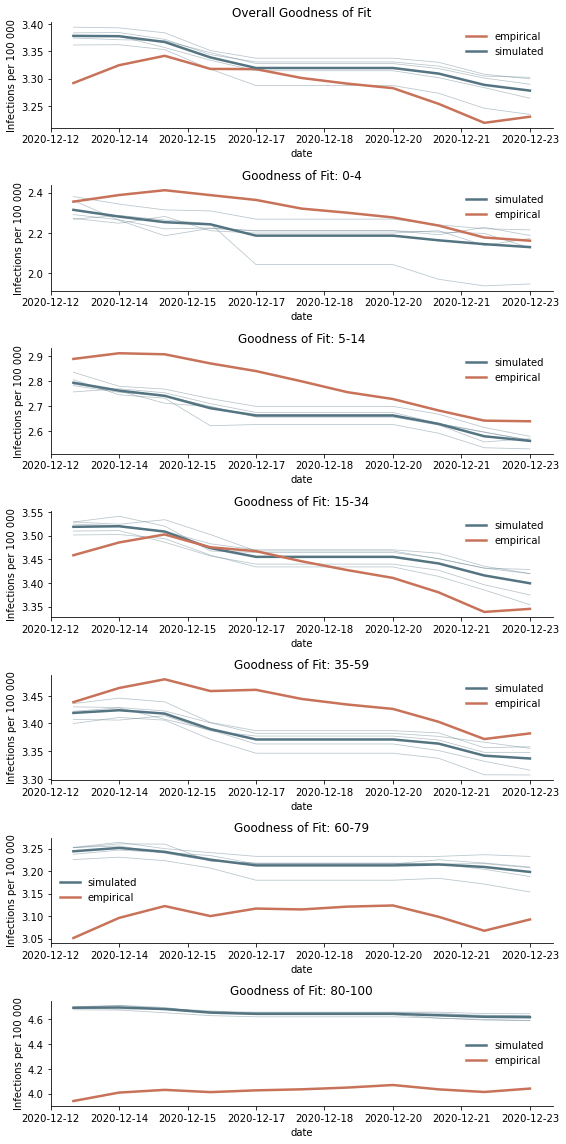

In [46]:
fig, ax = visualize_msm_evaluations(results, period=0)